In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mrmr import mrmr_classif

from src.machinelearning import (
    ANNClassifier,
    evaluate_ann,
    evaluate_sklearn,
    get_predictions,
    train_ann,
    train_decisiontree,
    train_skoperules,
    train_xgboost
)
from src.ml2rules import TreeRuler, ml2tree, sample_from_df
from src.utils import get_cc_mat, get_dataset, non_stratify_split, stratify_split

In [3]:
def plot_cc_ranges(df: pd.DataFrame) -> None:
    # Change plot style
    plt.style.use("ggplot")
    # Calculate the 1st and 3rd quartiles of df values
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    # Plot the mean of df values
    plt.figure(figsize=(10, 3))
    plt.barh(df.columns[::-1], df.mean()[::-1])
    plt.axvline(x=0, color="black", linestyle="-")
    plt.plot(q1, df.columns, "|", color="black", label="Q1", alpha=1)
    plt.plot(q3, df.columns, "|", color="black", label="Q3", alpha=1)
    for i, enzyme in enumerate(df.columns):
        plt.plot([q1[i], q3[i]], [enzyme, enzyme], color="black")
    plt.title("CC_XTR")
    plt.grid()
    plt.show()
    
def get_value_counts(df: pd.DataFrame) -> None:
    display(
        pd.DataFrame(
        data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
        index=["percentage", "absolute"]    
    ).T
    )


### Data loading

***Dataset shape: (200000, 259)

Enzyme: XTR
Common enzymes: ['HXK', 'PGI', 'TPI', 'ZWF', 'ATPM', 'ADK', 'NDR', 'PDA', 'XTR', 'XRI', 'XDH', 'XK']
Number of all enzymes: 86


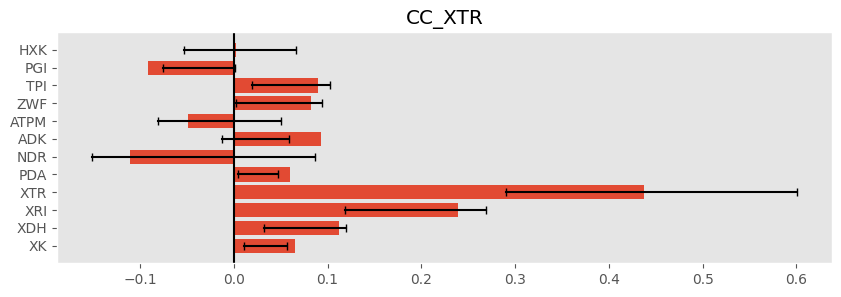

In [4]:
df = get_dataset(
    labels_file="../data/class_vector_train_ref.mat",
    params_file="../data/training_set_ref.mat",
    names_file="../data/paremeterNames.mat",
)

print(f"***Dataset shape: {df.shape}\n")

# Load FCC data
enzyme, commonEnz, allEnzymes, \
    commonConCoeff, allConCoeff = get_cc_mat("../data/ccXTR_ref.mat")

plot_cc_ranges(commonConCoeff)

In [5]:
# Create dataset for HXK enzyme; label 1 if CC < 0, 0 otherwise
idx_HXK = commonConCoeff[commonConCoeff["HXK"] < 0].index

df_HXK = df.drop("label", axis=1)
df_HXK["label"] = [1 if i in idx_HXK else 0 for i in df_HXK.index]
df_HXK["label"].value_counts(normalize=True).round(4)
df = df_HXK.copy()

# Create a dataframe with value_counts both percentage and absolute
display(
    pd.DataFrame(
    data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
    index=["percentage", "absolute"]    
).T
)

del df_HXK

,percentage,absolute
0,0.5287,105746.0
1,0.4713,94254.0


### Train - Test data split

In [16]:
# Split data
# X_train, X_test, y_train, y_test = non_stratify_split(
#     data=df, train_size=100000, target="label", zero_class_pct=0.60
# )

X_train, X_test, y_train, y_test = stratify_split(data=df, train_size=5000, target="label")

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print('Training set value counts:')
get_value_counts(train_df)

print('Test set value counts:')
get_value_counts(test_df)

Traininig set shape: (5000, 258)
Test set shape: (195000, 258)
Training set value counts:


,percentage,absolute
0,0.5288,2644.0
1,0.4712,2356.0


Test set value counts:


,percentage,absolute
0,0.5287,103102.0
1,0.4713,91898.0


### Feature Selection

In [17]:
# K = int(df.drop("label", axis=1).shape[1] / 4)
# print(f"***Number of features to select: {K}")
# selected_features = mrmr_classif(X=df.drop("label", axis=1), y=df["label"], K=K)

# # keep only selected features
# X_train = X_train[selected_features]
# X_test = X_test[selected_features]
# train_df = pd.concat([X_train, y_train], axis=1)
# test_df = pd.concat([X_test, y_test], axis=1)

# print(f'Training set shape: {train_df.shape}')
# print(f'Test set shape: {test_df.shape}')

### Machine Learning

##### Decision Tree - iSHRUNCK

In [18]:
cart_model = train_decisiontree(X_train, y_train, scoring='matthews_corrcoef', n_trials=25)

[I 2024-09-30 17:30:01,072] A new study created in memory with name: no-name-a09e1027-d810-451d-9572-98f6d46ca1de
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08733153343200684s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 17:30:01,283] Trial 0 finished with value: 0.05750464338967354 and parameters: {'max_depth': 21, 'min_samples_split': 25, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 0 with value: 0.05750464338967354.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.025) total time=   0.1s
[CV] END ................................ score: (test=0.033) total time=   0.1s
[CV] END ................................ score: (test=0.114) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.077) total time=   0.8s
[CV] END ................................ score: (test=0.096) total time=   0.9s
[CV] END ................................ score: (test=0.160) total time=   1.0s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[I 2024-09-30 17:30:02,388] Trial 1 finished with value: 0.11098053248063551 and parameters: {'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 1 with value: 0.11098053248063551.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09250783920288086s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 17:30:02,612] Trial 2 finished with value: 0.07229069886588448 and parameters: {'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.11098053248063551.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.074) total time=   0.1s
[CV] END ................................ score: (test=0.071) total time=   0.1s
[CV] END ................................ score: (test=0.072) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08271169662475586s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 17:30:02,827] Trial 3 finished with value: 0.03791510445855528 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.11098053248063551.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.022) total time=   0.1s
[CV] END ................................ score: (test=0.056) total time=   0.1s
[CV] END ................................ score: (test=0.036) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09133625030517578s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 17:30:03,042] Trial 4 finished with value: 0.09637662258230402 and parameters: {'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.11098053248063551.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.094) total time=   0.1s
[CV] END ................................ score: (test=0.065) total time=   0.1s
[CV] END ................................ score: (test=0.130) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 17:30:03,743] Trial 5 finished with value: 0.16776878233828538 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 5 with value: 0.16776878233828538.


[CV] END ................................ score: (test=0.151) total time=   0.5s
[CV] END ................................ score: (test=0.143) total time=   0.6s
[CV] END ................................ score: (test=0.209) total time=   0.6s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.015) total time=   0.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0660865306854248s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 17:30:03,938] Trial 6 finished with value: 0.05113913438560216 and parameters: {'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 5 with value: 0.16776878233828538.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] END ................................ score: (test=0.078) total time=   0.0s
[CV] END ................................ score: (test=0.060) total time=   0.1s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.150) total time=   0.0s
[CV] END ............................... score: (test=-0.020) total time=   0.1s
[CV] END ................................ score: (test=0.074) total time=   0.0s


[Parallel(n_jobs=-1)]: Batch computation too fast (0.0706946849822998s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 17:30:04,133] Trial 7 finished with value: 0.06804141449468744 and parameters: {'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.16776878233828538.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09074163436889648s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 17:30:04,360] Trial 8 finished with value: 0.06391630803802041 and parameters: {'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 24, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.16776878233828538.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.134) total time=   0.1s
[CV] END ................................ score: (test=0.074) total time=   0.1s
[CV] END ............................... score: (test=-0.015) total time=   0.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0471804141998291s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 17:30:04,535] Trial 9 finished with value: 0.06819222335521506 and parameters: {'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 5 with value: 0.16776878233828538.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.162) total time=   0.0s
[CV] END ............................... score: (test=-0.019) total time=   0.0s
[CV] END ................................ score: (test=0.062) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.098) total time=   0.7s
[CV] END ................................ score: (test=0.094) total time=   0.8s
[CV] END ................................ score: (test=0.123) total time=   0.8s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[I 2024-09-30 17:30:05,530] Trial 10 finished with value: 0.10513692538215351 and parameters: {'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 5 with value: 0.16776878233828538.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.069) total time=   0.9s
[CV] END ................................ score: (test=0.099) total time=   1.0s
[CV] END ................................ score: (test=0.138) total time=   1.0s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[I 2024-09-30 17:30:06,739] Trial 11 finished with value: 0.1020306426889056 and parameters: {'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 5 with value: 0.16776878233828538.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.095) total time=   0.7s
[CV] END ................................ score: (test=0.042) total time=   0.8s
[CV] END ................................ score: (test=0.146) total time=   0.9s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[I 2024-09-30 17:30:07,757] Trial 12 finished with value: 0.09410758138405732 and parameters: {'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 5 with value: 0.16776878233828538.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 17:30:08,618] Trial 13 finished with value: 0.17393758841209295 and parameters: {'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 13 with value: 0.17393758841209295.


[CV] END ................................ score: (test=0.146) total time=   0.7s
[CV] END ................................ score: (test=0.177) total time=   0.7s
[CV] END ................................ score: (test=0.199) total time=   0.7s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
[I 2024-09-30 17:30:09,536] Trial 14 finished with value: 0.15466438525871753 and parameters: {'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 13 with value: 0.17393758841209295.


[CV] END ................................ score: (test=0.121) total time=   0.7s
[CV] END ................................ score: (test=0.155) total time=   0.7s
[CV] END ................................ score: (test=0.189) total time=   0.8s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[I 2024-09-30 17:30:09,916] Trial 15 finished with value: 0.1675435047559722 and parameters: {'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 13 with value: 0.17393758841209295.


[CV] END ................................ score: (test=0.167) total time=   0.2s
[CV] END ................................ score: (test=0.154) total time=   0.2s
[CV] END ................................ score: (test=0.182) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 17:30:10,791] Trial 16 finished with value: 0.16253604098509747 and parameters: {'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 13 with value: 0.17393758841209295.


[CV] END ................................ score: (test=0.162) total time=   0.7s
[CV] END ................................ score: (test=0.138) total time=   0.7s
[CV] END ................................ score: (test=0.187) total time=   0.7s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[I 2024-09-30 17:30:11,652] Trial 17 finished with value: 0.1466994463709492 and parameters: {'max_depth': 8, 'min_samples_split': 22, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 13 with value: 0.17393758841209295.


[CV] END ................................ score: (test=0.131) total time=   0.7s
[CV] END ................................ score: (test=0.131) total time=   0.7s
[CV] END ................................ score: (test=0.178) total time=   0.7s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[I 2024-09-30 17:30:12,305] Trial 18 finished with value: 0.17719854697556062 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 18 with value: 0.17719854697556062.


[CV] END ................................ score: (test=0.152) total time=   0.5s
[CV] END ................................ score: (test=0.181) total time=   0.5s
[CV] END ................................ score: (test=0.199) total time=   0.5s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] END ................................ score: (test=0.081) total time=   1.0s
[CV] END ................................ score: (test=0.086) total time=   1.0s
[CV] END ................................ score: (test=0.149) total time=   1.1s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[I 2024-09-30 17:30:13,555] Trial 19 finished with value: 0.10528447792419175 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 18 with value: 0.17719854697556062.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.054085731506347656s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[I 2024-09-30 17:30:13,752] Trial 20 finished with value: 0.09773458424404709 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 18 with value: 0.17719854697556062.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ................................ score: (test=0.081) total time=   0.0s
[CV] END ................................ score: (test=0.054) total time=   0.0s
[CV] END ................................ score: (test=0.159) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 17:30:14,518] Trial 21 finished with value: 0.16536583045645417 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 18 with value: 0.17719854697556062.


[CV] END ................................ score: (test=0.148) total time=   0.6s
[CV] END ................................ score: (test=0.140) total time=   0.6s
[CV] END ................................ score: (test=0.208) total time=   0.6s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
[I 2024-09-30 17:30:15,425] Trial 22 finished with value: 0.1407366323766788 and parameters: {'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 18 with value: 0.17719854697556062.


[CV] END ................................ score: (test=0.107) total time=   0.8s
[CV] END ................................ score: (test=0.172) total time=   0.7s
[CV] END ................................ score: (test=0.143) total time=   0.8s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[I 2024-09-30 17:30:15,806] Trial 23 finished with value: 0.1675435047559722 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 18 with value: 0.17719854697556062.


[CV] END ................................ score: (test=0.154) total time=   0.2s
[CV] END ................................ score: (test=0.167) total time=   0.2s
[CV] END ................................ score: (test=0.182) total time=   0.2s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[I 2024-09-30 17:30:16,522] Trial 24 finished with value: 0.16801538194962876 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 18 with value: 0.17719854697556062.


[CV] END ................................ score: (test=0.154) total time=   0.5s
[CV] END ................................ score: (test=0.144) total time=   0.6s
[CV] END ................................ score: (test=0.206) total time=   0.6s


In [19]:
cart_model

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=3)

In [20]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(cart_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(cart_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.6630
Precision: 0.6327
Recall: 0.6791
F1 score: 0.6551
ROC AUC score: 0.6639
MCC: 0.3272

*** Evaluation on test set:
Accuracy: 0.5914
Precision: 0.5625
Recall: 0.5981
F1 score: 0.5798
ROC AUC score: 0.5918
MCC: 0.1832


In [27]:
ruler = TreeRuler(df=train_df, tree_clf=cart_model, target="label")
ruler.get_rules()
print(f'Number of rules: {len(ruler.rules)}')
ruler.rules

Number of rules: 31


['if (XRI@nadh_c <= 0.58) and (ASN@pi_m <= 0.652) and (PGK@dpg_c <= 0.939) and (GPD2@g3p_c <= 0.955) and (TPI@t3p_c > 0.298) then class: 0 (proba: 52.44%) | based on 1,293 samples',
 'if (XRI@nadh_c > 0.58) and (ASN@pi_m <= 0.693) and (XRI@nad_c <= 0.834) and (GND1@6pgl_c <= 0.926) and (XDH@xlt_c > 0.223) then class: 1 (proba: 79.17%) | based on 864 samples',
 'if (XRI@nadh_c <= 0.58) and (ASN@pi_m > 0.652) and (ASN@atp_m <= 0.739) and (GLYCt@glyc_c <= 0.866) and (XDH@xlt_c <= 0.977) then class: 0 (proba: 75.04%) | based on 597 samples',
 'if (XRI@nadh_c <= 0.58) and (ASN@pi_m <= 0.652) and (PGK@dpg_c <= 0.939) and (GPD2@g3p_c <= 0.955) and (TPI@t3p_c <= 0.298) then class: 1 (proba: 60.87%) | based on 552 samples',
 'if (XRI@nadh_c > 0.58) and (ASN@pi_m > 0.693) and (NDR@nadp_c <= 0.77) and (GND1@6pgl_c <= 0.832) and (BIO@accoa_c <= 0.702) then class: 1 (proba: 55.65%) | based on 248 samples',
 'if (XRI@nadh_c > 0.58) and (ASN@pi_m <= 0.693) and (XRI@nad_c <= 0.834) and (GND1@6pgl_c <=

In [38]:
rule = ruler.get_rule_constraints(2)
print(rule)
sampled_df = sample_from_df(train_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['XRI@nadh_c<=0.58', 'ASN@pi_m>0.652', 'ASN@atp_m<=0.739', 'GLYCt@glyc_c<=0.866', 'XDH@xlt_c<=0.977']
Number of parameter sets following the rule: 597


,percentage,absolute
1,0.7471,446.0
0,0.2529,151.0


##### Skope - Rules

In [44]:
skope_rules_clf = train_skoperules(X_train, y_train, scoring='matthews_corrcoef', n_iter=50)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 3/3; 1/50] START max_depth_duplication=1, max_samples=0.2, n_estimators=30, precision_min=0.2, recall_min=0.15
[CV 2/3; 9/50] START max_depth_duplication=1, max_samples=0.8, n_estimators=40, precision_min=0.25, recall_min=0.1
[CV 1/3; 1/50] START max_depth_duplication=1, max_samples=0.2, n_estimators=30, precision_min=0.2, recall_min=0.15
[CV 2/3; 2/50] START max_depth_duplication=None, max_samples=0.5, n_estimators=40, precision_min=0.15, recall_min=0.1
[CV 3/3; 5/50] START max_depth_duplication=1, max_samples=0.5, n_estimators=30, precision_min=0.3, recall_min=0.15
[CV 1/3; 8/50] START max_depth_duplication=None, max_samples=0.25, n_estimators=100, precision_min=0.1, recall_min=0.1
[CV 2/3; 8/50] START max_depth_duplication=None, max_samples=0.25, n_estimators=100, precision_min=0.1, recall_min=0.1
[CV 1/3; 4/50] START max_depth_duplication=1, max_samples=0.8, n_estimators=100, precision_min=0.3, recall_min=0.2
[CV 1/3

In [46]:
skope_rules_clf

SkopeRules(feature_names=['BIO@atp_c', 'BIO@pyr_c', 'BIO@nad_c', 'BIO@g6p_c',
                          'BIO@oaa_c', 'BIO@f6p_c', 'BIO@nadph_c', 'BIO@nh4_c',
                          'BIO@o2_c', 'BIO@r5p_c', 'BIO@3pg_c', 'BIO@akg_m',
                          'BIO@accoa_c', 'BIO@pep_c', 'BIO@e4p_c', 'BIO@so4_c',
                          'HXT@glc_c', 'HXK@atp_c', 'HXK@glc_c', 'HXK@adp_c',
                          'HXK@g6p_c', 'PGI@g6p_c', 'PGI@f6p_c', 'PFK@f6p_c',
                          'PFK@atp_c', 'PFK@fbp_c', 'PFK@adp_c', 'FBA@fbp_c',
                          'FBA@t3p_c', 'FBA@dhap_c', ...],
           max_depth_duplication=1, n_estimators=30, n_jobs=-1,
           precision_min=0.2, random_state=42, recall_min=0.25)

In [47]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(skope_rules_clf, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(skope_rules_clf, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.5758
Precision: 0.5409
Recall: 0.6600
F1 score: 0.5945
ROC AUC score: 0.5804
MCC: 0.1623

*** Evaluation on test set:
Accuracy: 0.5632
Precision: 0.5301
Recall: 0.6433
F1 score: 0.5812
ROC AUC score: 0.5675
MCC: 0.1362


In [55]:
# Print skope-rules rules
print(f'*** Number of rules {len(skope_rules_clf.rules_)}')

# Get rules
for i in skope_rules_clf.rules_:
    print(i)

*** Number of rules 2
('ASN@pi_m > 0.5139148533344269 and XDH@xyll_c > 0.01138218306005001 and XRI@nadh_c <= 0.5797132551670074', (0.6421343146274149, 0.3766864543982731, 2))
('ASN@pi_m <= 0.6838931441307068 and XRI@nadh_c <= 0.5804248452186584 and PGK@dpg_c <= 0.9149820506572723', (0.4901712111604312, 0.40260416666666665, 2))


In [56]:
_ = test_df[test_df['XRI@nadh_c'] <= 0.5797 ]
_ = _[_['ASN@pi_m'] > 0.5139 ]
_ = _[_['XDH@xyll_c'] > 0.01138]

get_value_counts(_)

,percentage,absolute
1,0.6123,32306.0
0,0.3877,20457.0


##### XGBoost

In [ ]:
xgb_model = train_xgboost(X_train, y_train, scoring='matthews_corrcoef', n_trials=5)

In [58]:
xgb_model

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10607826374544586,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=61, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [59]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(xgb_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(xgb_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 score: 1.0000
ROC AUC score: 1.0000
MCC: 1.0000

*** Evaluation on test set:
Accuracy: 0.6444
Precision: 0.6328
Recall: 0.5845
F1 score: 0.6077
ROC AUC score: 0.6411
MCC: 0.2841


In [ ]:
xgb_preds = xgb_model.predict(X_train)
xgb2tree = ml2tree(X_train, xgb_preds, scoring='matthews_corrcoef', n_trials=25)

In [64]:
xgb2tree

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=15)

In [65]:
evaluate_sklearn(xgb2tree, X_test, y_test)

Accuracy: 0.5912
Precision: 0.5972
Recall: 0.4072
F1 score: 0.4842
ROC AUC score: 0.5812
MCC: 0.1736


In [66]:
ruler = TreeRuler(df=train_df, tree_clf=xgb2tree, target="label")
ruler.get_rules()
ruler.rules

['if (XRI@nadh_c <= 0.58) and (ASN@pi_m <= 0.652) and (PGK@dpg_c <= 0.939) and (GPD2@g3p_c <= 0.955) then class: 1 (proba: 51.54%) | based on 1,845 samples',
 'if (XRI@nadh_c > 0.58) and (ASN@pi_m <= 0.693) and (XRI@nad_c <= 0.834) and (GND1@6pgl_c <= 0.926) then class: 1 (proba: 75.43%) | based on 1,103 samples',
 'if (XRI@nadh_c <= 0.58) and (ASN@pi_m > 0.652) and (ASN@atp_m <= 0.739) and (GLYCt@glyc_c <= 0.866) then class: 0 (proba: 74.01%) | based on 608 samples',
 'if (XRI@nadh_c > 0.58) and (ASN@pi_m > 0.693) and (NDR@nadp_c <= 0.77) and (GND1@6pgl_c <= 0.832) then class: 0 (proba: 51.03%) | based on 341 samples',
 'if (XRI@nadh_c <= 0.58) and (ASN@pi_m > 0.652) and (ASN@atp_m > 0.739) and (XDH@xlt_c <= 0.872) then class: 0 (proba: 57.81%) | based on 256 samples',
 'if (XRI@nadh_c > 0.58) and (ASN@pi_m <= 0.693) and (XRI@nad_c > 0.834) and (CO2m@co2_c > 0.157) then class: 1 (proba: 57.29%) | based on 199 samples',
 'if (XRI@nadh_c > 0.58) and (ASN@pi_m > 0.693) and (NDR@nadp_c > 

In [85]:
rule = ruler.get_rule_constraints(9)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['XRI@nadh_c>0.58', 'ASN@pi_m>0.693', 'NDR@nadp_c<=0.77', 'GND1@6pgl_c>0.832']
Number of parameter sets following the rule: 3015


,percentage,absolute
1,0.6219,1875.0
0,0.3781,1140.0


##### Neural Network

In [88]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = ANNClassifier(input_dim=X_train.shape[1], hidden_dim=2048,
                    output_dim=1, hidden_layers=4).to(device)

net = train_ann(net, X_train, y_train, num_epochs=1000, learning_rate=0.001, batch_size=2048)

Epoch 0, Loss: 0.692301
Epoch 10, Loss: 0.690674
Epoch 20, Loss: 0.692914
Epoch 30, Loss: 0.690311
Epoch 40, Loss: 0.639929
Epoch 50, Loss: 0.547455
Epoch 60, Loss: 0.433839
Epoch 70, Loss: 0.342109
Epoch 80, Loss: 0.050695
Epoch 90, Loss: 0.002344
Epoch 100, Loss: 0.000355
Epoch 110, Loss: 0.000160
Epoch 120, Loss: 0.000076
Epoch 130, Loss: 0.000037
Epoch 140, Loss: 0.000024
Epoch 150, Loss: 0.000014
Epoch 160, Loss: 0.000008
Epoch 170, Loss: 0.000004
Epoch 180, Loss: 0.000004
Epoch 190, Loss: 0.000002
Epoch 200, Loss: 0.000002
Epoch 210, Loss: 0.000001
Epoch 220, Loss: 0.000001
Epoch 230, Loss: 0.000001
Epoch 240, Loss: 0.000001
Epoch 250, Loss: 0.000001
Epoch 260, Loss: 0.000001
Epoch 270, Loss: 0.000001
Epoch 280, Loss: 0.000001
Epoch 290, Loss: 0.000000
Epoch 300, Loss: 0.000000
Epoch 310, Loss: 0.000000
Epoch 320, Loss: 0.000000
Epoch 330, Loss: 0.000000
Early stopping on epoch 330


In [90]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_ann(net, X_train, y_train)
print()

print('*** Evaluation on test set:')
evaluate_ann(net, X_test, y_test)

*** Evaluation on training set:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
MCC: 1.0000

*** Evaluation on test set:
Accuracy: 0.6388
Precision: 0.6192
Recall: 0.6066
F1: 0.6128
MCC: 0.2744


In [ ]:
ann_preds = get_predictions(net, X_train)
ann2tree = ml2tree(X_train, ann_preds, n_trials=25
                   )

In [92]:
ann2tree

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=23)

In [93]:
evaluate_sklearn(ann2tree, X_test, y_test)

Accuracy: 0.5931
Precision: 0.6078
Recall: 0.3848
F1 score: 0.4713
ROC AUC score: 0.5817
MCC: 0.1784


In [94]:
ruler = TreeRuler(df=train_df, tree_clf=ann2tree, target="label")
ruler.get_rules()
ruler.rules

['if (XRI@nadh_c <= 0.58) and (ASN@pi_m <= 0.652) and (PGK@dpg_c <= 0.939) then class: 1 (proba: 52.75%) | based on 1,924 samples',
 'if (XRI@nadh_c > 0.58) and (ASN@pi_m <= 0.693) and (XRI@nad_c <= 0.834) then class: 1 (proba: 73.31%) | based on 1,195 samples',
 'if (XRI@nadh_c <= 0.58) and (ASN@pi_m > 0.652) and (ASN@atp_m <= 0.739) then class: 0 (proba: 71.53%) | based on 685 samples',
 'if (XRI@nadh_c > 0.58) and (ASN@pi_m > 0.693) and (NDR@nadp_c <= 0.77) then class: 0 (proba: 55.92%) | based on 422 samples',
 'if (XRI@nadh_c <= 0.58) and (ASN@pi_m > 0.652) and (ASN@atp_m > 0.739) then class: 0 (proba: 54.06%) | based on 283 samples',
 'if (XRI@nadh_c > 0.58) and (ASN@pi_m <= 0.693) and (XRI@nad_c > 0.834) then class: 1 (proba: 51.45%) | based on 241 samples',
 'if (XRI@nadh_c <= 0.58) and (ASN@pi_m <= 0.652) and (PGK@dpg_c > 0.939) then class: 0 (proba: 75.37%) | based on 134 samples',
 'if (XRI@nadh_c > 0.58) and (ASN@pi_m > 0.693) and (NDR@nadp_c > 0.77) then class: 1 (proba: 7

In [102]:
rule = ruler.get_rule_constraints(2)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['XRI@nadh_c<=0.58', 'ASN@pi_m>0.652', 'ASN@atp_m<=0.739']
Number of parameter sets following the rule: 25510


,percentage,absolute
1,0.6786,17310.0
0,0.3214,8200.0


### Exlainable Machine Learning

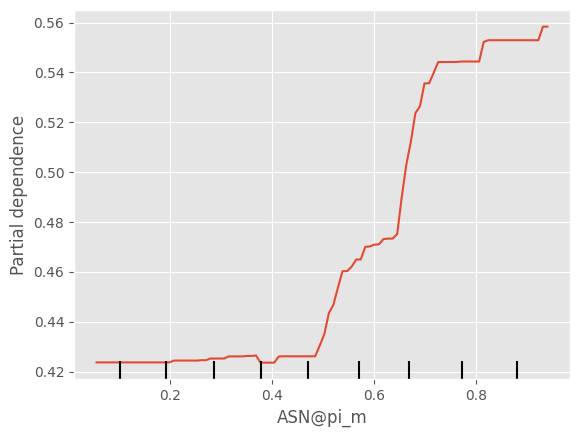

In [118]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=['ASN@pi_m'])
plt.show()

In [103]:
import shap

In [111]:
# Calculate shap values for xgb model
explainer = shap.DeepExplainer(net)
shap_values = explainer.shap_values(X_train)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataFrame

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="dot")